### Para tu proyecto de predicción de precios futuros de cierre de mercado de ETFs usando una red neuronal, te recomiendo seguir estos pasos para implementar la red neuronal de manera eficiente:

**1. Definir el objetivo y el tipo de modelo**
Objetivo: Tu objetivo es predecir el precio de cierre de los ETFs en el futuro, lo que hace que el problema sea de regresión. Esto significa que la red neuronal debe ser capaz de predecir un valor continuo (el precio).

Tipo de red neuronal: Utilizar una red neuronal recurrente (RNN), especialmente una LSTM (Long Short-Term Memory), es una excelente opción para este tipo de problema. Las LSTM son adecuadas para trabajar con series temporales porque pueden aprender patrones a largo plazo de los datos secuenciales, como los precios históricos de un ETF.

**2. Preparar los datos**
Recolección de datos: Recoge datos históricos de precios de cierre de los ETFs que te interesen. Esto puede incluir datos como el precio de apertura, máximo, mínimo, volumen, entre otros, que podrían mejorar la predicción si los añades como características adicionales.

*Preprocesamiento de los datos:*

Escalado de los datos: Es recomendable normalizar los datos antes de introducirlos en la red neuronal, ya que las redes neuronales funcionan mejor con datos que están en un rango similar. Puedes usar un Min-Max Scaling o una normalización Z-score.

Transformación a series temporales: Dado que estás trabajando con una serie temporal, debes estructurar los datos de manera que el modelo reciba ventanas de tiempo pasadas para predecir el futuro. Por ejemplo, usar los precios de los últimos 30 días para predecir el precio del siguiente día.

División de datos: Divide los datos en conjunto de entrenamiento, conjunto de validación y conjunto de prueba.

**3. Diseño de la red neuronal**
Entrada: La entrada de la red serán las características de los días anteriores (por ejemplo, precios de cierre de los últimos 30 días).

*Capas:*

Capa LSTM: La capa LSTM es la parte central de la red para captar las dependencias temporales a largo plazo.

Capa densa (Fully Connected): Después de la capa LSTM, utiliza una o más capas densas para realizar la predicción.

Salida: La salida será un valor continuo (el precio de cierre para el próximo día o período).

Función de activación: La capa de salida no necesita activación si la predicción es un valor continuo.

Función de pérdida: Usa una función de pérdida como MSE (Mean Squared Error), ya que es un problema de regresión.

Optimizador: Utiliza un optimizador como Adam para entrenar la red neuronal.

**4. Entrenamiento y evaluación**
Entrenamiento: Entrena el modelo usando el conjunto de entrenamiento y valida el rendimiento en el conjunto de validación. Ajusta los hiperparámetros como el número de capas, el número de unidades LSTM, la tasa de aprendizaje, entre otros, según los resultados.

Evaluación: Una vez que el modelo esté entrenado, evalúa su rendimiento en el conjunto de prueba. Compara las predicciones con los valores reales y usa métricas como el RMSE (Root Mean Squared Error) para evaluar la precisión del modelo.

**5. Mejoras y optimización**
Ajuste de hiperparámetros: Realiza una búsqueda de hiperparámetros (grid search o random search) para encontrar la mejor configuración de la red.

Regularización: Si el modelo tiene problemas de sobreajuste (overfitting), puedes agregar regularización L2 o técnicas como dropout.

Feature engineering: Experimenta con diferentes características, como indicadores técnicos (RSI, MACD, etc.), para mejorar las predicciones.

**6. Implementación y predicción en tiempo real**
Una vez que el modelo esté entrenado, puedes usarlo para hacer predicciones en tiempo real o en un entorno de producción.

## FILTRAGE DE DATOS

In [ ]:
import pandas as pd

# 1. Cargar datos
df = pd.read_csv('/content/top20_ETFs.csv')

# 2. Preparar columna de trimestre
df['price_date'] = pd.to_datetime(df['price_date'])
df['trimestre'] = df['price_date'].dt.to_period('Q').astype(str)

# 3. Calcular la mediana por ETF y Trimestre
medianas = df.groupby(['fund_symbol', 'trimestre'])['close'].median().reset_index()
medianas.rename(columns={'close': 'mediana_close'}, inplace=True)

# 4. Unir las medianas al DataFrame original
df = df.merge(medianas, on=['fund_symbol', 'trimestre'])

# 5. Filtrar los valores que coinciden con la mediana exactamente
df_mediana = df[df['close'] == df['mediana_close']]

# 6. Mostrar solo los índices
indices_mediana = df_mediana.index

# Mostrar el DataFrame con índices y columnas clave
print(df_mediana[['fund_symbol', 'trimestre', 'close']])

      fund_symbol trimestre  close
23            SPY    1993Q1  44.88
36            SPY    1993Q1  44.88
37            SPY    1993Q1  44.88
54            SPY    1993Q2  44.75
78            SPY    1993Q2  44.75
...           ...       ...    ...
62319         QLD    2021Q2  64.80
62327        SOXL    2021Q2  39.04
62395        AMER    2021Q2  31.64
62667         USD    2021Q3  35.75
63757         USD    2021Q3  35.75

[1059 rows x 3 columns]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose

df_etf20 = pd.read_csv('top20_ETFs.csv')
df_top20 = df_etf20.copy()

In [ ]:
# Cargar el dataset
df_new = df_top20.copy()

# Convertir la columna 'price_date' a tipo datetime
df_new["price_date"] = pd.to_datetime(df_new["price_date"])

# Agrupar por 'fund_symbol' y por trimestre usando resample (con la columna 'price_date')
df_trimestral = df_new.groupby("fund_symbol").resample('Q', on='price_date').agg({
    'open': 'median',
    'high': 'median',
    'low': 'median',
    'close': 'median',
    'adj_close': 'median',
    'volume': 'sum',  # Sumar el volumen total por trimestre
    'Clasificacion': 'first',  # Tomar la clasificación del primer registro del trimestre
    'Rentabilidad': 'median',  # Promediar la rentabilidad
    'Rentabilidad_Porcentaje': 'median'  # Promediar la rentabilidad en porcentaje
}).reset_index()

# Mostrar las primeras filas del DataFrame resultante
print(df_trimestral.head())

<ipython-input-8-915bd8a4e8f2>:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_trimestral = df_new.groupby("fund_symbol").resample('Q', on='price_date').agg({


  fund_symbol price_date    open    high     low   close  adj_close  volume  \
0        AMER 2020-12-31  25.640  25.690  25.500  25.570     25.140  378100   
1        AMER 2021-03-31  28.050  28.050  27.880  27.910     27.540  559900   
2        AMER 2021-06-30  31.640  31.640  31.610  31.640     31.350   50300   
3        AMER 2021-09-30  31.015  31.015  31.015  31.015     30.875   30000   
4        AMER 2021-12-31  31.190  31.190  31.190  31.190     31.190    8100   

   Clasificacion  Rentabilidad  Rentabilidad_Porcentaje  
0              6     44.522388                  4452.24  
1              6     44.522388                  4452.24  
2              6     44.522388                  4452.24  
3              6     44.522388                  4452.24  
4              6     44.522388                  4452.24  


In [ ]:
# Asegúrate de que "Clasificacion" esté en formato numérico (por si acaso)
df_top20['Clasificacion'] = pd.to_numeric(df_top20['Clasificacion'], errors='coerce')

# Filtrar los 5 primeros ETFs según clasificación
top5_etfs = df_top20[['fund_symbol', 'Clasificacion']].drop_duplicates().sort_values('Clasificacion').head(5)['fund_symbol'].tolist()

# Crear un nuevo DataFrame solo con esos ETFs
df_top5 = df_top20[df_top20['fund_symbol'].isin(top5_etfs)]

In [ ]:
df_top20.head(10)

,fund_symbol,price_date,open,high,low,close,adj_close,volume,Clasificacion,Rentabilidad,Rentabilidad_Porcentaje
0,SPY,1993-01-29,43.97,43.97,43.75,43.94,25.80,1003200,13,16.657364,1665.74
1,SPY,1993-02-01,43.97,44.25,43.97,44.25,25.98,480500,13,16.657364,1665.74
2,SPY,1993-02-02,44.22,44.38,44.12,44.34,26.04,201300,13,16.657364,1665.74
3,SPY,1993-02-03,44.41,44.84,44.38,44.81,26.31,529400,13,16.657364,1665.74
4,SPY,1993-02-04,44.97,45.09,44.47,45.00,26.42,531500,13,16.657364,1665.74
5,SPY,1993-02-05,44.97,45.06,44.72,44.97,26.41,492100,13,16.657364,1665.74
6,SPY,1993-02-08,44.97,45.12,44.91,44.97,26.41,596100,13,16.657364,1665.74
7,SPY,1993-02-09,44.81,44.81,44.56,44.66,26.22,122100,13,16.657364,1665.74
8,SPY,1993-02-10,44.66,44.75,44.53,44.72,26.26,379600,13,16.657364,1665.74
9,SPY,1993-02-11,44.78,45.12,44.78,44.94,26.39,19500,13,16.657364,1665.74


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - loss: 0.0085
Epoch 2/5
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - loss: 0.0078
Epoch 3/5
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - loss: 0.0079
Epoch 4/5
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - loss: 0.0080
Epoch 5/5
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - loss: 0.0080
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


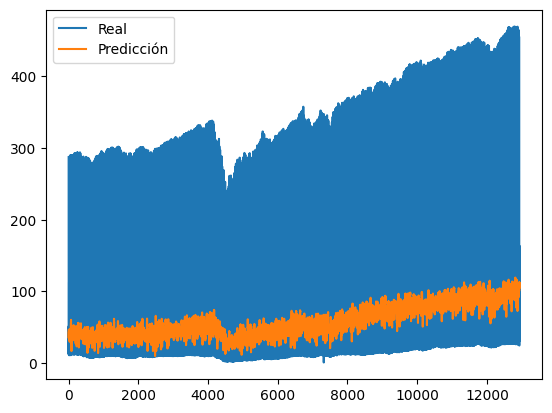

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Cargar datos (ejemplo con datos históricos de precios de un ETF)
data = df_top20.copy()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))

# Crear secuencias de datos para la red neuronal
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para que el modelo reciba entradas de la forma [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Hacer predicciones
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluar el modelo
import matplotlib.pyplot as plt
plt.plot(y_test, label='Real')
plt.plot(predictions, label='Predicción')
plt.legend()
plt.show()
